In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
!gunzip /content/cc.fa.300.bin.gz
!wget https://raw.githubusercontent.com/Mehrdadghassabi/Persian-Sentiment-Analyzer/master/better_dataset/train.csv
!wget https://raw.githubusercontent.com/Mehrdadghassabi/Persian-Sentiment-Analyzer/master/better_dataset/dev.csv
!pip install hazm
!pip install sentencepiece
!pip install transformers
!pip install fasttext

--2022-02-20 15:30:37--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4502524724 (4.2G) [application/octet-stream]
Saving to: ‘cc.fa.300.bin.gz’

cc.fa.300.bin.gz    100%[===================>]   4.19G  33.1MB/s    in 2m 7s   

2022-02-20 15:32:45 (33.7 MB/s) - ‘cc.fa.300.bin.gz’ saved [4502524724/4502524724]

--2022-02-20 15:34:02--  https://raw.githubusercontent.com/Mehrdadghassabi/Persian-Sentiment-Analyzer/master/better_dataset/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [2]:
import fasttext 
import pandas
import random
import numpy
import hazm
import numpy as np
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification  
from transformers import TFAutoModelForTokenClassification  
from transformers import pipeline
import matplotlib.pyplot as plt

In [3]:
def clean_text(text):
  normalizer = hazm.Normalizer()
  text = normalizer.normalize(text)
  return text

In [4]:
the_size = 300 
maxlen = 20 
batch =  500
count =  7
txt = "کیفیت بد سرویس بد تر تف توش"

In [5]:
Word_vectors = fasttext.load_model("/content/cc.fa.300.bin")
train = pandas.read_csv("/content/train.csv", sep='	')
dev = pandas.read_csv("/content/dev.csv", sep='	')
train_list = list(map(lambda x: [clean_text(x[0]),x[1]],zip(train['comment'],train['label_id'])))
dev_list = list(map(lambda x: [clean_text(x[0]),x[1]],zip(dev['comment'],dev['label_id'])))
good=list(filter(lambda x: x[1] == 0,train_list))
bad=list(filter(lambda x: x[1] == 1,train_list))
train_list = good[:] + bad[:]
good=list(filter(lambda x: x[1] == 0,dev_list))
bad=list(filter(lambda x: x[1] == 1,dev_list))
dev_list = good[:] + bad[:]
train_size=len(train_list)
dev_size=len(dev_list)
x_train = np.zeros((train_size, maxlen, the_size), dtype=K.floatx())
y_train = np.zeros((train_size, 2), dtype=np.int32)
x_test = np.zeros((dev_size, maxlen, the_size), dtype=K.floatx())
y_test = np.zeros((dev_size, 2), dtype=np.int32)

for i in range(train_size):
  text_words = hazm.word_tokenize(train_list[i][0])
  for t in range(0,len(text_words)):
    if t >= maxlen:
      break
    if text_words[t] not in Word_vectors.words:
      continue
    x_train[i, t, :] = Word_vectors.get_word_vector(text_words[t])
  if train_list[i][1] == 1:
    y_train[i, :] = [1.0, 0.0]
  else:
    y_train[i, :] = [0.0, 1.0]

for i in range(dev_size):
  text_words = hazm.word_tokenize(dev_list[i][0])
  for t in range(0,len(text_words)):
    if t >= maxlen:
      break
    if text_words[t] not in Word_vectors.words:
      continue
    x_test[i, t, :] = Word_vectors.get_word_vector(text_words[t])
  if dev_list[i][1] == 1:
    y_test[i, :] = [1.0, 0.0]
  else:
    y_test[i, :] = [0.0, 1.0]

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same',
                 input_shape=(maxlen, the_size)))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=3))
model.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.3)))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
history = model.fit(x_train, y_train, batch_size=batch, shuffle=True, epochs=count,
         validation_data=(x_test, y_test))
model.save('best_model.h5')

Epoch 1/7
114/114 [==============================] - 139s 1s/step - loss: 0.7043 - accuracy: 0.5437 - val_loss: 0.5545 - val_accuracy: 0.7284
Epoch 2/7
114/114 [==============================] - 131s 1s/step - loss: 0.4783 - accuracy: 0.7844 - val_loss: 0.4301 - val_accuracy: 0.8006
Epoch 3/7
114/114 [==============================] - 131s 1s/step - loss: 0.4248 - accuracy: 0.8142 - val_loss: 0.4204 - val_accuracy: 0.8119
Epoch 4/7
114/114 [==============================] - 131s 1s/step - loss: 0.4096 - accuracy: 0.8214 - val_loss: 0.4100 - val_accuracy: 0.8210
Epoch 5/7
114/114 [==============================] - 131s 1s/step - loss: 0.4053 - accuracy: 0.8246 - val_loss: 0.4057 - val_accuracy: 0.8219
Epoch 6/7
114/114 [==============================] - 145s 1s/step - loss: 0.3961 - accuracy: 0.8298 - val_loss: 0.4059 - val_accuracy: 0.8248
Epoch 7/7
114/114 [==============================] - 131s 1s/step - loss: 0.3928 - accuracy: 0.8324 - val_loss: 0.3975 - val_accuracy: 0.8276


In [7]:

nrm = hazm.Normalizer()
normaltxt = nrm.normalize(txt)
txtoken = hazm.word_tokenize(normaltxt)
vecs = np.zeros((1,maxlen,the_size),dtype=K.floatx())
for t in range(0,len(txtoken)):
  if t >= maxlen:
    break
  if txtoken[t] not in Word_vectors.words:
    continue
    
  vecs[0, t, :] = Word_vectors.get_word_vector(txtoken[t])

res = model.predict(vecs)
goodpr = str(res[0][1]*100)+" % "
badpr = str(res[0][0]*100)+" % "
print("badpr: "+badpr)
print("goodpr: "+goodpr)

badpr: 92.04574227333069 % 
goodpr: 7.9542554914951324 % 


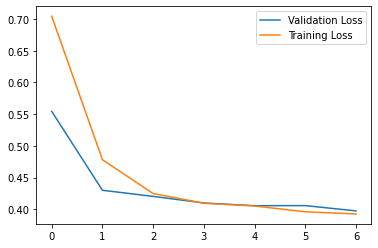

In [8]:
trainloss = history.history['loss']
valloss = history.history['val_loss']
plt.plot(valloss)
plt.plot(trainloss)
plt.legend(['Validation Loss','Training Loss'])
plt.show()